# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# установим нужные библиотеки
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузим датасет
df = pd.read_csv('/datasets/autos.csv')

In [3]:
# создадим функцию, которая покажет всю общую информацию о датасете
def show_info(df_name):  
    display(df_name.head(10))
    print('-------------------------------------------')
    print(df_name.info())
    print('-------------------------------------------')
    print(df_name.describe())
    print('-------------------------------------------')
    df_name.hist(figsize=(15, 20));

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           35436

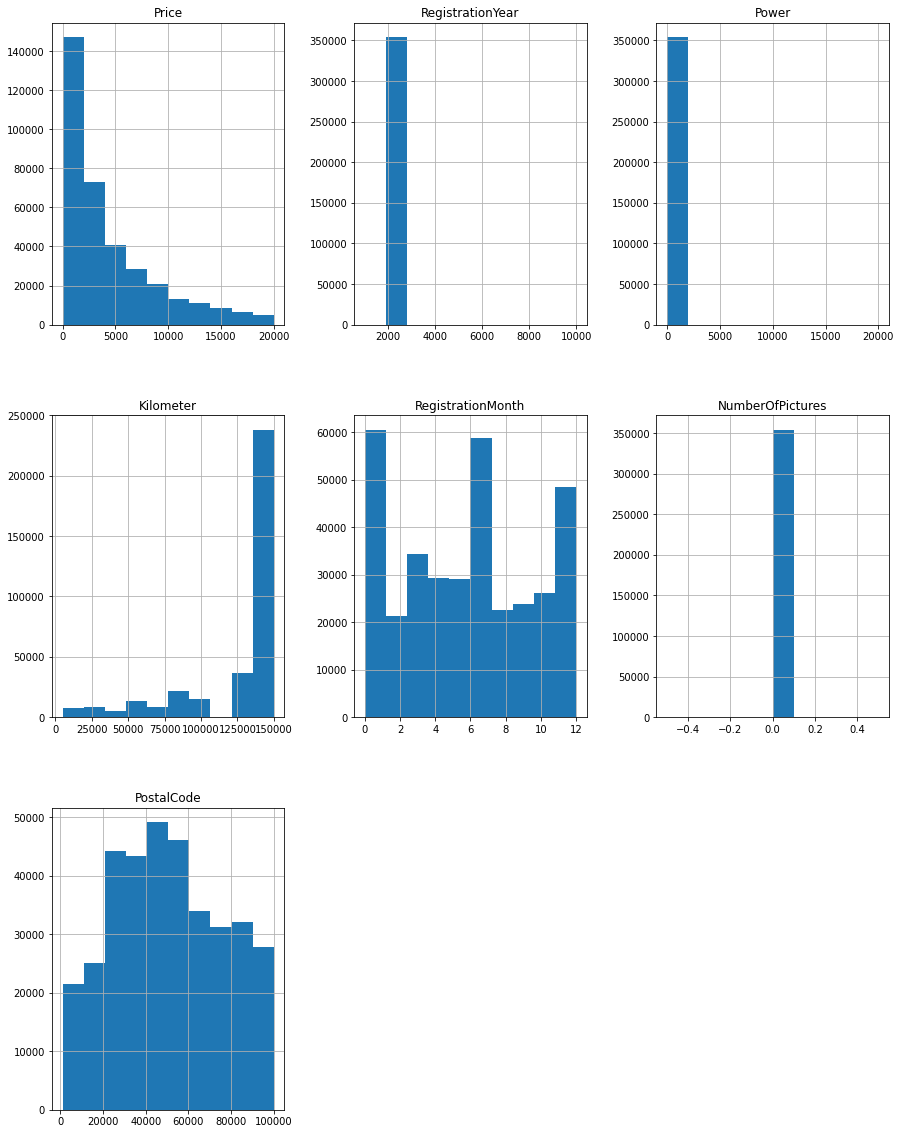

In [4]:
show_info(df)

Из полученных данных мы можем видеть, что в датасете есть пропуски, неверные типы данных, неправильные названия столбцов, выбросы, а также не нужные столбцы. Приступим к очистке данных.

In [5]:
# исправим названия столбцов
df = df.rename(columns = {'DateCrawled': 'date_crawled', 'VehicleType': 'vehicle_type', 'RegistrationYear':
                         'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 'Kilometer': 
                          'kilometer', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand',
                         'Repaired': 'repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 
                          'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen', 'Price': 'price'})

In [6]:
# исправим тип данных для столбцов с датами
df['date_crawled'] = df['date_crawled'].astype('datetime64')
df['date_created'] = df['date_created'].astype('datetime64')
df['last_seen'] = df['last_seen'].astype('datetime64')

In [7]:
# найдем количество пропусков в столбцах
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [8]:
# посмотрим какие значения содержат столбцы с пропусками
print('Значения типа автомобильного кузова:', df['vehicle_type'].unique())
print()
print('Значения типа коробки передач:', df['gearbox'].unique())
print()
print('Значения модели автомобиля:', df['model'].unique())
print()
print('Значения типа топлива:', df['fuel_type'].unique())
print()
print('Значения столбца repaired:', df['repaired'].unique())

Значения типа автомобильного кузова: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Значения типа коробки передач: ['manual' 'auto' nan]

Значения модели автомобиля: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modu

In [9]:
# заполним пропуски в 3-х категориальных столбцах на 'other'
df['vehicle_type'] = df['vehicle_type'].fillna('other')
df['model'] = df['model'].fillna('other')
df['fuel_type'] = df['fuel_type'].fillna('other')

In [10]:
''' так как в столбцах 'gearbox' и 'repaired' присутствуют 2 значения (не считая пропусков), и пустые значения мы не знаем, чем 
заполнить, то лучшим вариантом будет их исключение из исследования.'''
df = df.dropna() 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276170 entries, 1 to 354367
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        276170 non-null  datetime64[ns]
 1   price               276170 non-null  int64         
 2   vehicle_type        276170 non-null  object        
 3   registration_year   276170 non-null  int64         
 4   gearbox             276170 non-null  object        
 5   power               276170 non-null  int64         
 6   model               276170 non-null  object        
 7   kilometer           276170 non-null  int64         
 8   registration_month  276170 non-null  int64         
 9   fuel_type           276170 non-null  object        
 10  brand               276170 non-null  object        
 11  repaired            276170 non-null  object        
 12  date_created        276170 non-null  datetime64[ns]
 13  number_of_pictures  276170 no

In [12]:
# проверим датасет на дубликаты
df.duplicated().sum()

4

In [13]:
# удалим дубли из датасета
df = df.drop_duplicates()

In [14]:
df.duplicated().sum()

0

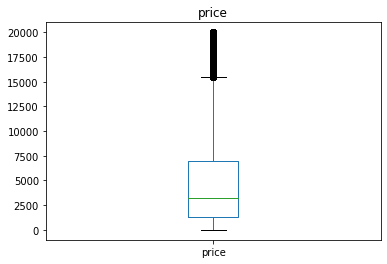

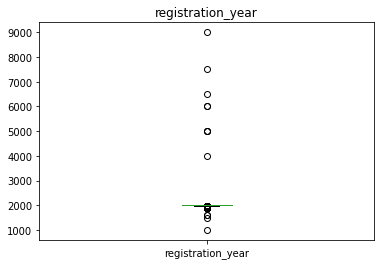

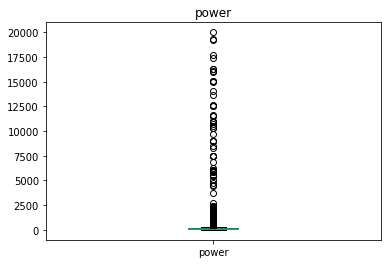

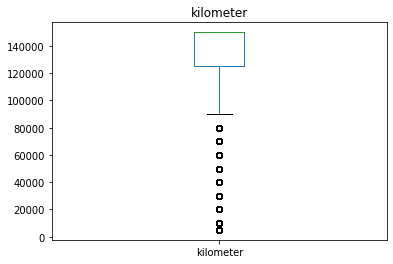

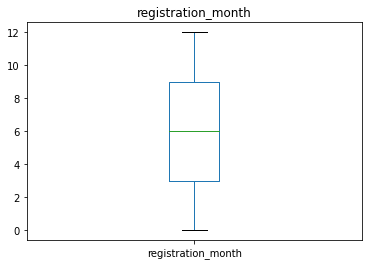

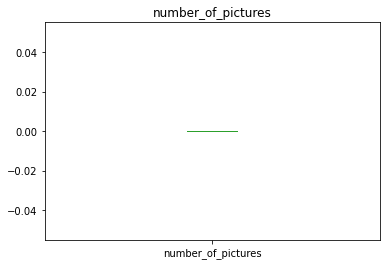

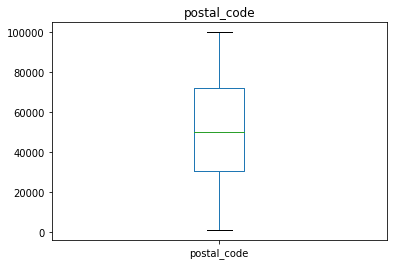

In [15]:
# теперь рассмотрим выбросы на графиках
for col in ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures', 'postal_code']:
    df[col].plot.box()
    plt.title(col)
    plt.show()

Исходя из представленных графиков избавимся от выбросов по году регистрации, мощности и цене.

In [16]:
# для установления корректного потолка года, найдем дату последнего скачивания заявления
df['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

In [17]:
# по информации из графиков уберем все выбросы в нашем датасете
df = df.query('1950 < registration_year < 2023 and 50 < power < 600 and 100 < price')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248307 entries, 1 to 354367
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        248307 non-null  datetime64[ns]
 1   price               248307 non-null  int64         
 2   vehicle_type        248307 non-null  object        
 3   registration_year   248307 non-null  int64         
 4   gearbox             248307 non-null  object        
 5   power               248307 non-null  int64         
 6   model               248307 non-null  object        
 7   kilometer           248307 non-null  int64         
 8   registration_month  248307 non-null  int64         
 9   fuel_type           248307 non-null  object        
 10  brand               248307 non-null  object        
 11  repaired            248307 non-null  object        
 12  date_created        248307 non-null  datetime64[ns]
 13  number_of_pictures  248307 no

In [19]:
# теперь создадим столбцы отдельно день, месяц и год из столбца 'date_created'
df['weekday'] = df['date_created'].dt.weekday
df['month'] = df['date_created'].dt.month
df['year'] = df['date_created'].dt.year

In [20]:
# и удалим ненужные столбцы
df = df.drop(['date_crawled', 'last_seen', 'date_created', 'registration_month', 'number_of_pictures', 
                  'postal_code'], axis=1)

In [21]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,weekday,month,year
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes,3,3,2016
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,3,3,2016
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3,3,2016
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,0,4,2016
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,4,4,2016


**Вывод:** Нам удалось установить, что в представленном датасете есть много пропусков, выбросов, неверные типы данных, неправильные названия столбцов. После проведенной очистки данных мы получили датасет готовый к проведению дальнейшего исследования и построению моделей машинного обучения.

## Обучение моделей

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248307 entries, 1 to 354367
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              248307 non-null  int64 
 1   vehicle_type       248307 non-null  object
 2   registration_year  248307 non-null  int64 
 3   gearbox            248307 non-null  object
 4   power              248307 non-null  int64 
 5   model              248307 non-null  object
 6   kilometer          248307 non-null  int64 
 7   fuel_type          248307 non-null  object
 8   brand              248307 non-null  object
 9   repaired           248307 non-null  object
 10  weekday            248307 non-null  int64 
 11  month              248307 non-null  int64 
 12  year               248307 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 26.5+ MB


In [25]:
# теперь выделим целевой признак
features = df.drop('price', axis=1)
target = df['price']

In [26]:
# теперь разделим данные на обучающую и тестовую выборки 
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=25)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=25)

In [27]:
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(148984,)
(49661,)
(49662,)


In [28]:
# прямое кодирование
encoder = OrdinalEncoder()
categorical = df.select_dtypes(include='object').columns.to_list() + ['weekday', 'month', 'year']
cat_features = features_train[categorical]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
features_train = features_train.copy()
for column in categorical:
    features_train[column] = cat_features[column]
    
cat_features_v = features_valid[categorical]
cat_features_v = pd.DataFrame(encoder.transform(cat_features_v),
                                columns=cat_features_v.columns, 
                                index=cat_features_v.index)
features_valid = features_valid.copy()
for column in categorical:
    features_valid[column] = cat_features_v[column]
    
cat_features_t = features_test[categorical]
cat_features_t = pd.DataFrame(encoder.transform(cat_features_t),
                                columns=cat_features_t.columns, 
                                index=cat_features_t.index)
features_test = features_test.copy()
for column in categorical:
    features_test[column] = cat_features_t[column]

# OHE кодирование
ohe_features_train = pd.get_dummies(features_train, drop_first=True)
ohe_features_valid = pd.get_dummies(features_valid, drop_first=True)
ohe_features_test = pd.get_dummies(features_test, drop_first=True)

### Модель LightGBM 

In [29]:
parameters_lgbm = {'max_depth':[1, 30], 'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[25], 'class_weight': ['balanced', None]}
model_lgbm = LGBMRegressor()
grid_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=parameters_lgbm, cv=5)

In [30]:
%%time

# проверим скорость обучения модели LightGBM 
grid_lgbm.fit(features_train, target_train)

CPU times: user 40min 20s, sys: 23 s, total: 40min 43s
Wall time: 40min 55s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [1, 30],
                         'random_state': [25]})

In [31]:
%%time

# проверим скорость предсказания модели LightGBM

predict_lgbm = grid_lgbm.predict(features_valid)

CPU times: user 292 ms, sys: 0 ns, total: 292 ms
Wall time: 199 ms


In [33]:
# проверим качество предсказания RMSE модели LightGBM
print('RMSE модели LightGBM:', mean_squared_error(target_valid, predict_lgbm)**(.5))

RMSE модели LightGBM: 1657.3192543903629


### Модель LinearRegression

In [34]:
parameters_LR = {'normalize':[True,False], 'fit_intercept':[True,False]}
model_LR = LinearRegression()
grid_LR = GridSearchCV(estimator=model_LR, param_grid=parameters_LR, cv=5)

In [35]:
%%time

# проверим скорость обучения модели LinearRegression
grid_LR.fit(ohe_features_train, target_train)

CPU times: user 1.76 s, sys: 2.68 s, total: 4.44 s
Wall time: 4.39 s


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]})

In [36]:
%%time

# проверим скорость предсказания модели LinearRegression

predict_lr = grid_LR.predict(ohe_features_valid)

CPU times: user 30.6 ms, sys: 4.03 ms, total: 34.7 ms
Wall time: 27.6 ms


In [37]:
# проверим качество предсказания RMSE модели LinearRegression
print('RMSE модели LinearRegression:', mean_squared_error(target_valid, predict_lr)**(.5))

RMSE модели LinearRegression: 2956.393088253965


### Модель RandomForestRegressor

In [38]:
parameters_RFR = {'n_estimators':[1, 100], 'max_depth':[1, 30], 
                  'random_state':[25]}
model_RFR = RandomForestRegressor()
grid_RFR = GridSearchCV(estimator=model_RFR, param_grid=parameters_RFR, cv=5)

In [39]:
%%time

# проверим скорость обучения модели RandomForestRegressor
grid_RFR.fit(features_train, target_train)

CPU times: user 3min 50s, sys: 6.82 s, total: 3min 57s
Wall time: 3min 57s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 30], 'n_estimators': [1, 100],
                         'random_state': [25]})

In [40]:
%%time

# проверим скорость предсказания модели RandomForestRegressor

predict_rfr = grid_RFR.predict(features_valid)

CPU times: user 2.5 s, sys: 19.9 ms, total: 2.52 s
Wall time: 2.52 s


In [41]:
# проверим качество предсказания RMSE модели RandomForestRegressor
print('RMSE модели RandomForestRegressor:', mean_squared_error(target_valid, predict_rfr)**(.5))

RMSE модели RandomForestRegressor: 1668.2472116192107


### Модель DecisionTreeRegressor

In [42]:
parameters_DTR = {'max_depth':[1,30], 'random_state':[25]}
model_DTR = DecisionTreeRegressor()
grid_DTR = GridSearchCV(estimator=model_DTR, param_grid=parameters_DTR, cv=5)

In [43]:
%%time

# проверим скорость обучения модели DecisionTreeRegressor
grid_DTR.fit(features_train, target_train)

CPU times: user 3.79 s, sys: 35.9 ms, total: 3.83 s
Wall time: 3.83 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 30], 'random_state': [25]})

In [44]:
%%time

# проверим скорость предсказания модели DecisionTreeRegressor

predict_dtr = grid_DTR.predict(features_valid)

CPU times: user 31.2 ms, sys: 41 µs, total: 31.3 ms
Wall time: 29.4 ms


In [45]:
# проверим качество предсказания RMSE модели DecisionTreeRegressor
print('RMSE модели DecisionTreeRegressor:', mean_squared_error(target_valid, predict_dtr)**(.5))

RMSE модели DecisionTreeRegressor: 2164.188493739665


**Вывод:** На основе очищенного датасета нам удалось построить 4-ре модели машинного обучения, каждая из которых демонстрирует различные показатели по скорости обучения, скорости предсказания и оценки RMSE.

## Анализ моделей

In [46]:
# запишем получившиеся результаты
data = [['40min 55s', '199 ms', 1657.32],
        ['4.39 s', '27.6 ms', 2956.39],
        ['3min 57s', '2.52 s', 1668.25],
        ['3.83 s', '29.4 ms', 2164.19]]
models = ['LightGBM', 'LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor']

In [47]:
# построим таблицу с нашими значениями
pd.DataFrame(data=data, index=models, columns=['Время обучения', 'Скорость предсказания', 'Оценка RMSE'])

,Время обучения,Скорость предсказания,Оценка RMSE
LightGBM,40min 55s,199 ms,1657.32
LinearRegression,4.39 s,27.6 ms,2956.39
RandomForestRegressor,3min 57s,2.52 s,1668.25
DecisionTreeRegressor,3.83 s,29.4 ms,2164.19


In [48]:
# проверим модель на тестовой выборке
predict_rfr = grid_RFR.predict(features_test)

In [49]:
# проверим качество предсказания RMSE модели RandomForestRegressor на тестовой выборке
print('RMSE модели RandomForestRegressor:', mean_squared_error(target_test, predict_rfr)**(.5))

RMSE модели RandomForestRegressor: 1651.9432084834955


На тестовой выборке модель RandomForestRegressor показала схожий результат RMSE. Модель не переобучена, можно брать в работу.

**Вывод:** Мы видим, что самой лучшей по качеству предсказания оказалась модель RandomForestRegressor, самой худшей - модель LinearRegression. При этом, по времени обучения RandomForestRegressor является самой долгой, а самой быстрой - модель DecisionTreeRegressor.

## Общий вывод

*Модели LightGBM и RandomForestRegressor	показывают лучший результат оценки RMSE, но долго обучаются. А модели LinearRegression и DecisionTreeRegressor наоборот: быстро учаться, но оценка RMSE сравнительно велика. Поэтому если для клиента не так важна скорость обучения, как оценка RMSE, то рекомендуем использовать модель LightGBM или RandomForestRegressor.*